In [1]:
#%matplotlib widget
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
#%matplotlib inline
%matplotlib widget

In [2]:
import tqdm 
import torch

import numpy as np
import matplotlib.pyplot as plt

from ripser import ripser
from persim import plot_diagrams

import utils

plt.style.use("bioAI.mplstyle")


import sys
from pathlib import Path

# Plotting
import copy

'''
CUSTOM PACKAGES
'''
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None

from plotting_functions import *
from synthetic_grid_cells import GridModule, rotation_matrix
from methods import multiimshow2, PCA_UMAP, filenames
from Experiment import Experiment
from stats import *

/home/m/miniconda3/envs/ml/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/m/miniconda3/envs/ml/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/m/miniconda3/envs/ml/lib/python3.11/site-packages/umap/distances.py:1086: NumbaD

In [3]:
# Load ratemaps and module indices
base_path = "../"
#base_path = "/mnt/WD12TB-HDD"
experiment = utils.load_experiment(base_path, "gg-3ME")
save_loc = f"{experiment.paths['experiment']}/"

# ---> select cells by manifold (gardner et al.) <---
module_indices = np.load(f"{experiment.paths['experiment']}/module_indices_all_clusters.npz")
clusters = [module_indices[f] for f in module_indices.files]
 
if (grid_cells:= False):
    module_indices = np.array(list(clusters[1])) # grid-like units
    cell_type = "grid_cells"
else:
    module_indices = np.array(list(clusters[2]) + list(clusters[12]) + list(clusters[15])) # band-like units
    cell_type = "band_cells"


Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


In [4]:
ratemaps = []
for env_i in range(3):
    with open(experiment.paths['ratemaps'] / (f'env_{env_i}/' + filenames(experiment.paths['ratemaps'] / f'env_{env_i}')[-1]), 'rb') as f:
        tmp_ratemaps = pickle.load(f)
        # fix nans
        tmp_ratemaps = np.array([fill_nan(ratemap, method='nearest') for ratemap in tmp_ratemaps])
        ratemaps.append(tmp_ratemaps)
ratemaps = np.stack(ratemaps)

ratemaps.shape

(3, 4096, 64, 64)

In [5]:
ratemaps = ratemaps[:,module_indices]
ratemaps.shape

(3, 604, 64, 64)

/home/m/miniconda3/envs/ml/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  self.figure.savefig(buf, format='png', dpi='figure')


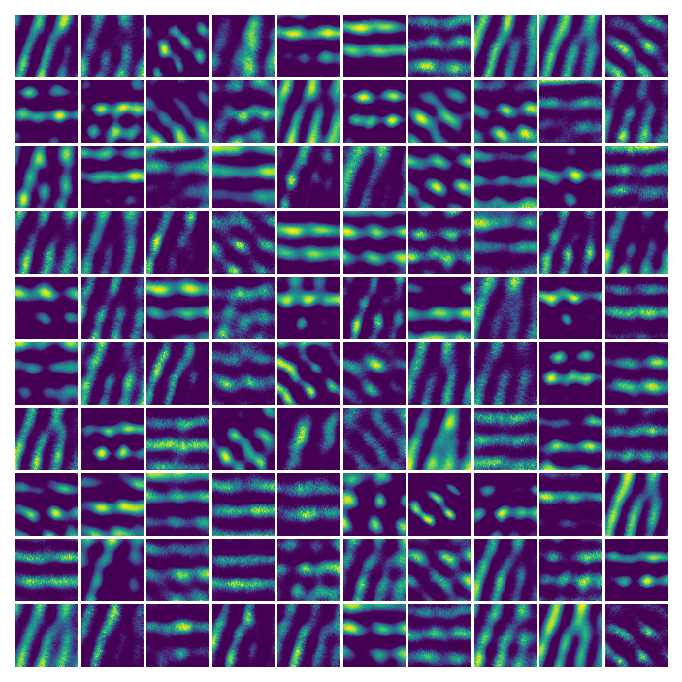

In [6]:
multiimshow2(ratemaps[0][:100], figsize = (5,5), normalize = False, axes_pad=0.02);

In [7]:
g = np.reshape(ratemaps, (*ratemaps.shape[:2], -1)) # flatten bins
g = np.transpose(g, (0, -1, 1)) # move cell dim to end
g.shape

(3, 4096, 604)

In [8]:
umap_fits = []
pca_fits= []

for i in tqdm.tqdm(range(len(g))):
    pca_fit, umap_fit = PCA_UMAP(g[i], n_neighbors = 4000, metric = "euclidean", min_dist = 0.8)
    pca_fits.append(pca_fit)
    umap_fits.append(umap_fit)

100%|██████████| 3/3 [05:38<00:00, 112.69s/it]


In [16]:
metric = "cosine"
bins = ratemaps.shape[-1]

# for 64x64 ratemaps:
k = 1000
ns = 3000

ph_lims = [-0.05, 1.2, -0.05, 1.2] # limits of persistent homology, for comparing 

downsample_inds = []

for i in range(len(pca_fits)):
    full_pca = pca_fits[i]
    inds, d, Fdfsf = utils.downsample_pointcloud(full_pca, k, ns, metric)
    downsample_inds.append(inds)

In [10]:
def normalize_pointcloud(pointcloud):
    pointcloud = (pointcloud - np.mean(pointcloud, axis = 0, keepdims=True))
    pointcloud /= np.amax(pointcloud)
    return pointcloud

/tmp/ipykernel_17836/3233468393.py:15: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0,hspace=0)


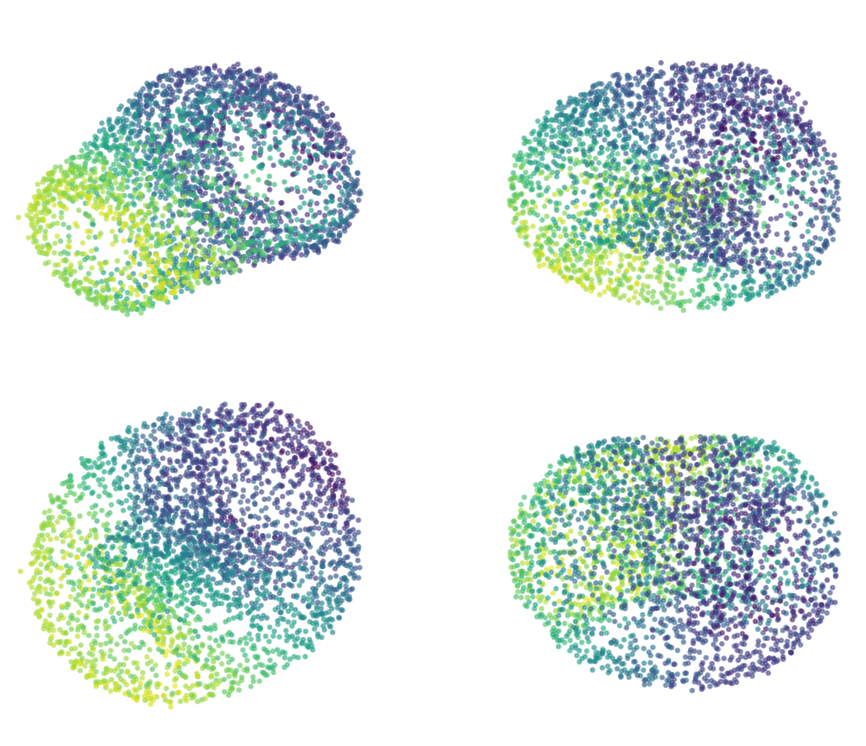

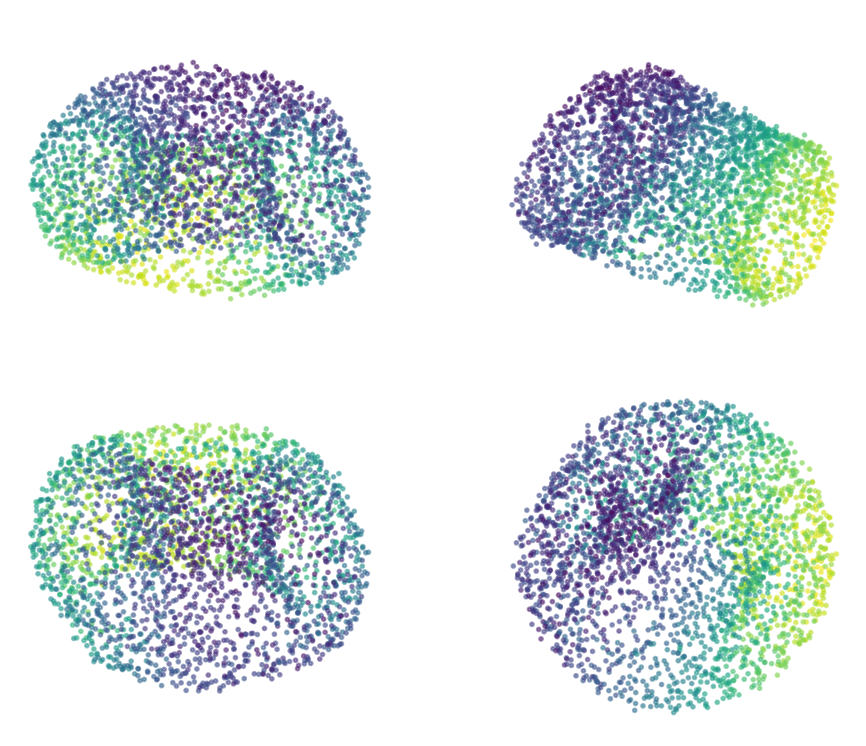

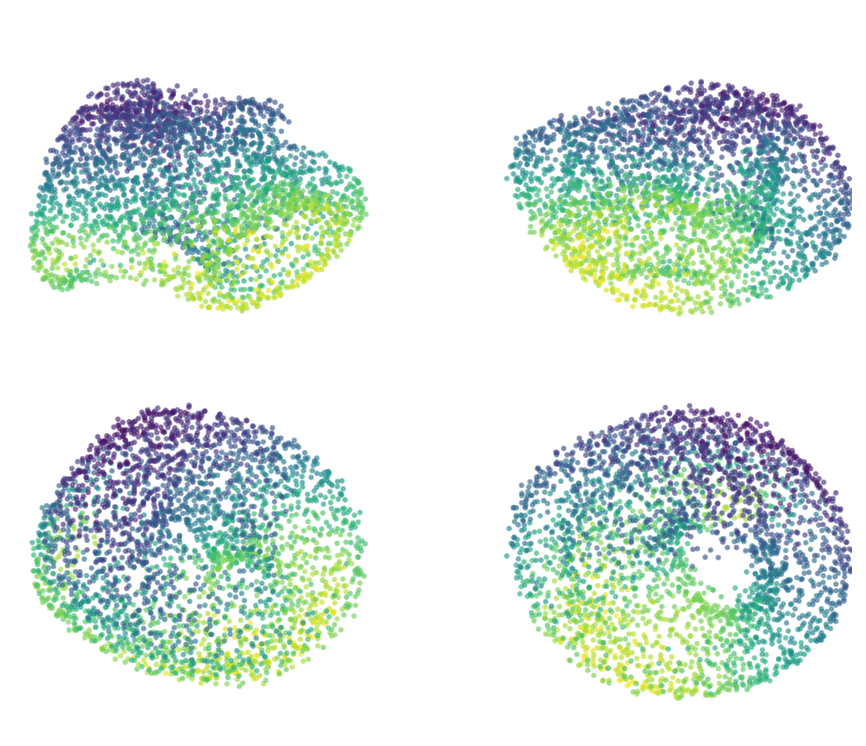

In [11]:
figs = [] # save figures with camera pose

for env in range(3):

    normalized = normalize_pointcloud(umap_fits[env])[downsample_inds[env]]
    color = pca_fits[env][:,0][downsample_inds[env]]

    fig, axs = scatter3d(normalized, color, azim_elev_title = False, s = 3, alpha = 0.5, edgecolor = None)
    figs.append(fig)
    for ax in np.ravel(axs):
        RADIUS = 0.65 # Control this value.
        ax.set_xlim3d(-RADIUS, RADIUS)
        ax.set_zlim3d(-RADIUS, RADIUS)
        ax.set_ylim3d(-RADIUS, RADIUS)
    plt.subplots_adjust(wspace=0,hspace=0)


In [12]:
#[fig.savefig(f"../../{cell_type}_low_dim_env_{env}") for env, fig in enumerate(figs)]

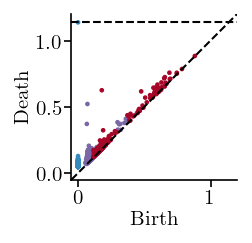

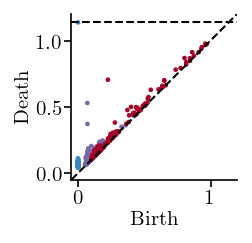

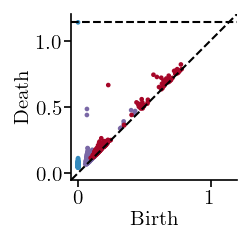

In [17]:
# Then we can compute persistent homology

for i, inds in enumerate(downsample_inds):
    downsampled_pca = pca_fits[i][inds]
    dgms = ripser(downsampled_pca, n_perm = 500,  maxdim=2, coeff=47, metric = metric)['dgms']
    plt.figure(figsize=(1.5, 1.5))
    plot_diagrams(dgms, show=False, colormap = "bioAI.mplstyle", size = 5, legend = False, xy_range = ph_lims)
    
    #plt.xlabel("")
    #plt.ylabel("")
    plt.savefig(f'../../env_{i}_{cell_type}_ph')


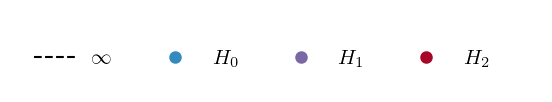

In [24]:
# Make custom legends, the stupid way
# plt.figure(figsize=(3.5,0.5))
# plt.figure(figsize=(1,1))

# for elem, name in zip(["--", ".", ".", "."], ["$$\infty$$", "$$H_0$$","$$H_1$$","$$H_2$$"]):
#     if elem == "--":
#         plt.plot(0, elem, label = name, color = "k")
#     else:
#         plt.plot(0, elem, label = name, markersize = 10)
# plt.axis([-1.01, -1, -1.01, -1])
# plt.axis("off")

# plt.legend()
# plt.savefig(f'../../ph_legend_band')

# plt.legend(loc = "lower left", ncol = 4)
# plt.savefig(f'../../ph_legend_gc')
